In [ ]:
!pip install transformers datasets rouge_score
!pip install py7zr
!pip install gradio
!pip install sacrebleu bert-score

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.7 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=3eb6a7507e8fe053da4036c2f06bb95f04d7bc6972c0d628cea110637febfd22
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that a

bart and bleu

In [ ]:
import torch
from datasets import load_dataset
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
from torch.utils.data import DataLoader
import torch.amp
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import corpus_bleu
from bert_score import score as bertscore
import matplotlib.pyplot as plt
import numpy as np
import gradio as gr

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the SAMSum Dataset
dataset = load_dataset("samsum", trust_remote_code=True)
train_data = dataset["train"]
validation_data = dataset["validation"]
test_data = dataset["test"]

# Load Pre-trained PEGASUS Model and Tokenizer
model_name = "google/pegasus-cnn_dailymail"
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name).to(device)

# Preprocessing Function
def preprocess_data(examples, tokenizer, max_input_len=256, max_target_len=64):
    inputs = tokenizer(examples['dialogue'], max_length=max_input_len, truncation=True, padding="max_length", return_tensors="pt")
    targets = tokenizer(examples['summary'], max_length=max_target_len, truncation=True, padding="max_length", return_tensors="pt")
    return {"input_ids": inputs.input_ids.squeeze(),
            "attention_mask": inputs.attention_mask.squeeze(),
            "labels": targets.input_ids.squeeze()}

# Preprocess the datasets
train_data = train_data.map(lambda x: preprocess_data(x, tokenizer), batched=True)
validation_data = validation_data.map(lambda x: preprocess_data(x, tokenizer), batched=True)
test_data = test_data.map(lambda x: preprocess_data(x, tokenizer), batched=True)

# Convert Dataset to PyTorch DataLoader
def to_dataloader(dataset, batch_size=4):
    def collate_fn(batch):
        input_ids = torch.stack([torch.tensor(ex['input_ids']) for ex in batch])
        attention_mask = torch.stack([torch.tensor(ex['attention_mask']) for ex in batch])
        labels = torch.stack([torch.tensor(ex['labels']) for ex in batch])
        return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': labels}

    return DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

train_dataloader = to_dataloader(train_data)
validation_dataloader = to_dataloader(validation_data)
test_dataloader = to_dataloader(test_data)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.04k [00:00<?, ?B/s]

samsum.py:   0%|          | 0.00/3.36k [00:00<?, ?B/s]

corpus.7z:   0%|          | 0.00/2.94M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Epoch 1/3, Loss: nan
Epoch 2/3, Loss: 0.6934135120454088
Epoch 3/3, Loss: nan


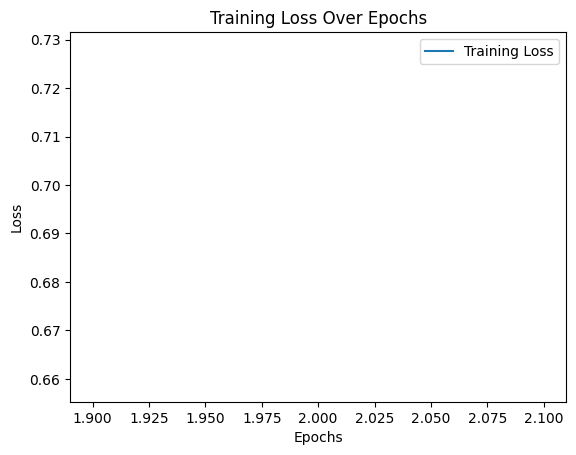

In [ ]:

# Define Optimizer and Scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

# Gradient Accumulation and Mixed Precision Training
accumulation_steps = 2
scaler = torch.amp.GradScaler('cuda')

# Gradient Clipping Value
max_grad_norm = 1.0

# Fine-tuning Loop with Gradient Accumulation and Mixed Precision
epochs = 3
train_losses = []

model.train()
for epoch in range(epochs):
    total_loss = 0
    optimizer.zero_grad()

    for i, batch in enumerate(train_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        with torch.amp.autocast('cuda'):
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss / accumulation_steps

        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(train_dataloader):
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += loss.item() * accumulation_steps

    avg_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_loss)
    scheduler.step()  # Update learning rate
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss}")

# Plot Training Loss
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.show()

In [ ]:

# Evaluation Function
def evaluate_model(dataloader, model, tokenizer):
    rouge_scores = {"rouge1": [], "rouge2": [], "rougeL": []}
    references = []
    candidates = []

    model.eval()
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Decode the original dialogues
        with torch.no_grad():
            summary_ids = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=128)

        generated_summaries = tokenizer.batch_decode(summary_ids, skip_special_tokens=True)
        reference_summaries = tokenizer.batch_decode(labels, skip_special_tokens=True)

        # For BLEU and BERT-Score
        candidates.extend(generated_summaries)
        references.extend([[ref] for ref in reference_summaries])

        # Compute ROUGE
        for ref, gen in zip(reference_summaries, generated_summaries):
            scores = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True).score(ref, gen)
            rouge_scores["rouge1"].append(scores["rouge1"].fmeasure)
            rouge_scores["rouge2"].append(scores["rouge2"].fmeasure)
            rouge_scores["rougeL"].append(scores["rougeL"].fmeasure)

    # Average ROUGE Scores
    avg_rouge_scores = {metric: np.mean(scores) for metric, scores in rouge_scores.items()}

    # Compute BLEU Score
    bleu_score = corpus_bleu(references, candidates)

    # Compute BERT-Score
    P, R, F1 = bertscore(candidates, [ref[0] for ref in references], lang="en", rescale_with_baseline=True)
    bert_score = {"Precision": P.mean().item(), "Recall": R.mean().item(), "F1": F1.mean().item()}

    return avg_rouge_scores, bleu_score, bert_score

# Evaluate on Test Set
test_rouge_scores, test_bleu_score, test_bert_score = evaluate_model(test_dataloader, model, tokenizer)

print("Test ROUGE Scores:", test_rouge_scores)
print("Test BLEU Score:", test_bleu_score)
print("Test BERT-Score:", test_bert_score)

# Interactive Gradio Demo
def summarize_dialogue(dialogue):
    inputs = tokenizer(dialogue, max_length=256, truncation=True, return_tensors="pt").to(device)
    summary_ids = model.generate(inputs["input_ids"], max_length=128, num_beams=4, early_stopping=True)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

gr.Interface(fn=summarize_dialogue,
             inputs="text",
             outputs="text",
             title="Dialogue Summarizer with PEGASUS").launch()


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test ROUGE Scores: {'rouge1': 0.4526723014353415, 'rouge2': 0.21895184893503505, 'rougeL': 0.3603667901790511}
Test BLEU Score: 0.44163491150475725
Test BERT-Score: {'Precision': 0.40776774287223816, 'Recall': 0.5232843160629272, 'F1': 0.4647409915924072}
Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://642059cd01adb246b1.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


t5


In [ ]:
import torch
from datasets import load_dataset
from transformers import T5ForConditionalGeneration, T5Tokenizer
from torch.utils.data import DataLoader
import torch.amp
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import corpus_bleu
from bert_score import score as bertscore
import matplotlib.pyplot as plt
import numpy as np
import gradio as gr

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the SAMSum Dataset
dataset = load_dataset("samsum", trust_remote_code=True)
train_data = dataset["train"]
validation_data = dataset["validation"]
test_data = dataset["test"]

# Load Pre-trained T5 Model and Tokenizer
model_name = "t5-small"  # You can replace with another T5 variant like "t5-base" or "t5-large" if you need a larger model
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name).to(device)

# Preprocessing Function
def preprocess_data(examples, tokenizer, max_input_len=256, max_target_len=64):
    inputs = tokenizer(examples['dialogue'], max_length=max_input_len, truncation=True, padding="max_length", return_tensors="pt")
    targets = tokenizer(examples['summary'], max_length=max_target_len, truncation=True, padding="max_length", return_tensors="pt")
    return {"input_ids": inputs.input_ids.squeeze(),
            "attention_mask": inputs.attention_mask.squeeze(),
            "labels": targets.input_ids.squeeze()}

# Preprocess the datasets
train_data = train_data.map(lambda x: preprocess_data(x, tokenizer), batched=True)
validation_data = validation_data.map(lambda x: preprocess_data(x, tokenizer), batched=True)
test_data = test_data.map(lambda x: preprocess_data(x, tokenizer), batched=True)

# Convert Dataset to PyTorch DataLoader
def to_dataloader(dataset, batch_size=4):
    def collate_fn(batch):
        input_ids = torch.stack([torch.tensor(ex['input_ids']) for ex in batch])
        attention_mask = torch.stack([torch.tensor(ex['attention_mask']) for ex in batch])
        labels = torch.stack([torch.tensor(ex['labels']) for ex in batch])
        return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': labels}

    return DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

train_dataloader = to_dataloader(train_data)
validation_dataloader = to_dataloader(validation_data)
test_dataloader = to_dataloader(test_data)



Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch 1/3, Loss: 1.6633381464705983
Epoch 2/3, Loss: 0.9666005192957201
Epoch 3/3, Loss: 0.9377652931773336


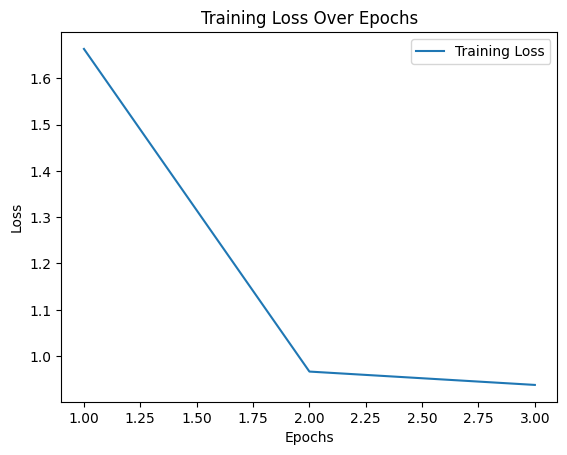

In [ ]:

# Define Optimizer and Scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

# Gradient Accumulation and Mixed Precision Training
accumulation_steps = 2
scaler = torch.amp.GradScaler('cuda')

# Gradient Clipping Value
max_grad_norm = 1.0

# Fine-tuning Loop with Gradient Accumulation and Mixed Precision
epochs = 3
train_losses = []

model.train()
for epoch in range(epochs):
    total_loss = 0
    optimizer.zero_grad()

    for i, batch in enumerate(train_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        with torch.amp.autocast('cuda'):
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss / accumulation_steps

        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(train_dataloader):
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += loss.item() * accumulation_steps

    avg_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_loss)
    scheduler.step()  # Update learning rate
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss}")

# Plot Training Loss
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.show()

In [ ]:

# Evaluation Function
def evaluate_model(dataloader, model, tokenizer):
    rouge_scores = {"rouge1": [], "rouge2": [], "rougeL": []}
    references = []
    candidates = []

    model.eval()
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Decode the original dialogues
        with torch.no_grad():
            summary_ids = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=128)

        generated_summaries = tokenizer.batch_decode(summary_ids, skip_special_tokens=True)
        reference_summaries = tokenizer.batch_decode(labels, skip_special_tokens=True)

        # For BLEU and BERT-Score
        candidates.extend(generated_summaries)
        references.extend([[ref] for ref in reference_summaries])

        # Compute ROUGE
        for ref, gen in zip(reference_summaries, generated_summaries):
            scores = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True).score(ref, gen)
            rouge_scores["rouge1"].append(scores["rouge1"].fmeasure)
            rouge_scores["rouge2"].append(scores["rouge2"].fmeasure)
            rouge_scores["rougeL"].append(scores["rougeL"].fmeasure)

    # Average ROUGE Scores
    avg_rouge_scores = {metric: np.mean(scores) for metric, scores in rouge_scores.items()}

    # Compute BLEU Score
    bleu_score = corpus_bleu(references, candidates)

    # Compute BERT-Score
    P, R, F1 = bertscore(candidates, [ref[0] for ref in references], lang="en", rescale_with_baseline=True)
    bert_score = {"Precision": P.mean().item(), "Recall": R.mean().item(), "F1": F1.mean().item()}

    return avg_rouge_scores, bleu_score, bert_score

# Evaluate on Test Set
test_rouge_scores, test_bleu_score, test_bert_score = evaluate_model(test_dataloader, model, tokenizer)

print("Test ROUGE Scores:", test_rouge_scores)
print("Test BLEU Score:", test_bleu_score)
print("Test BERT-Score:", test_bert_score)

# Interactive Gradio Demo
def summarize_dialogue(dialogue):
    inputs = tokenizer(dialogue, max_length=256, truncation=True, return_tensors="pt").to(device)
    summary_ids = model.generate(inputs["input_ids"], max_length=128, num_beams=4, early_stopping=True)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

gr.Interface(fn=summarize_dialogue,
             inputs="text",
             outputs="text",
             title="Dialogue Summarizer with T5").launch()


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test ROUGE Scores: {'rouge1': 0.39658270353981645, 'rouge2': 0.1615033554953515, 'rougeL': 0.32461969007230157}
Test BLEU Score: 0.3559109471658765
Test BERT-Score: {'Precision': 0.4492340683937073, 'Recall': 0.3640291690826416, 'F1': 0.4062049388885498}
Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://89185a1849c1cef5af.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


facebook/bart-large-cnn

In [ ]:
import torch
from datasets import load_dataset
from transformers import BartForConditionalGeneration, BartTokenizer
from torch.utils.data import DataLoader
import torch.amp
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import corpus_bleu
from bert_score import score as bertscore
import matplotlib.pyplot as plt
import numpy as np
import gradio as gr

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the SAMSum Dataset
dataset = load_dataset("samsum", trust_remote_code=True)
train_data = dataset["train"]
validation_data = dataset["validation"]
test_data = dataset["test"]

# Load Pre-trained BART Model and Tokenizer
model_name = "facebook/bart-large-cnn"
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name).to(device)

# Preprocessing Function
def preprocess_data(examples, tokenizer, max_input_len=256, max_target_len=64):
    inputs = tokenizer(examples['dialogue'], max_length=max_input_len, truncation=True, padding="max_length", return_tensors="pt")
    targets = tokenizer(examples['summary'], max_length=max_target_len, truncation=True, padding="max_length", return_tensors="pt")
    return {"input_ids": inputs.input_ids.squeeze(),
            "attention_mask": inputs.attention_mask.squeeze(),
            "labels": targets.input_ids.squeeze()}

# Preprocess the datasets
train_data = train_data.map(lambda x: preprocess_data(x, tokenizer), batched=True)
validation_data = validation_data.map(lambda x: preprocess_data(x, tokenizer), batched=True)
test_data = test_data.map(lambda x: preprocess_data(x, tokenizer), batched=True)

# Convert Dataset to PyTorch DataLoader
def to_dataloader(dataset, batch_size=4):
    def collate_fn(batch):
        input_ids = torch.stack([torch.tensor(ex['input_ids']) for ex in batch])
        attention_mask = torch.stack([torch.tensor(ex['attention_mask']) for ex in batch])
        labels = torch.stack([torch.tensor(ex['labels']) for ex in batch])
        return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': labels}

    return DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

train_dataloader = to_dataloader(train_data)
validation_dataloader = to_dataloader(validation_data)
test_dataloader = to_dataloader(test_data)


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Epoch 1/3, Loss: 0.721401619520357
Epoch 2/3, Loss: 0.5130478028848285
Epoch 3/3, Loss: 0.4168379483822892


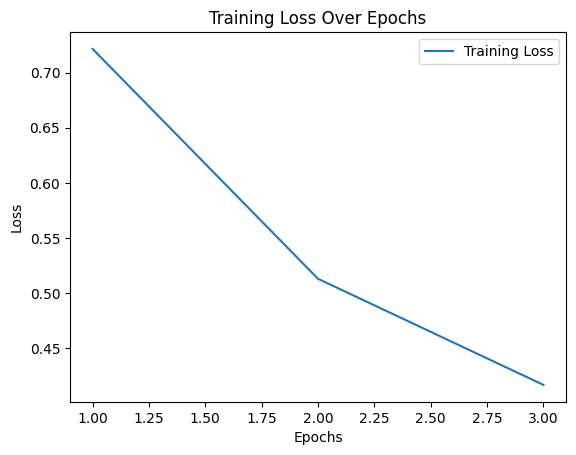

In [ ]:

# Define Optimizer and Scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

# Gradient Accumulation and Mixed Precision Training
accumulation_steps = 2
scaler = torch.amp.GradScaler('cuda')

# Gradient Clipping Value
max_grad_norm = 1.0

# Fine-tuning Loop with Gradient Accumulation and Mixed Precision
epochs = 3
train_losses = []

model.train()
for epoch in range(epochs):
    total_loss = 0
    optimizer.zero_grad()

    for i, batch in enumerate(train_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        with torch.amp.autocast('cuda'):
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss / accumulation_steps

        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(train_dataloader):
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += loss.item() * accumulation_steps

    avg_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_loss)
    scheduler.step()  # Update learning rate
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss}")

# Plot Training Loss
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.show()


In [ ]:

# Evaluation Function
def evaluate_model(dataloader, model, tokenizer):
    rouge_scores = {"rouge1": [], "rouge2": [], "rougeL": []}
    references = []
    candidates = []

    model.eval()
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Decode the original dialogues
        with torch.no_grad():
            summary_ids = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=128)

        generated_summaries = tokenizer.batch_decode(summary_ids, skip_special_tokens=True)
        reference_summaries = tokenizer.batch_decode(labels, skip_special_tokens=True)

        # For BLEU and BERT-Score
        candidates.extend(generated_summaries)
        references.extend([[ref] for ref in reference_summaries])

        # Compute ROUGE
        for ref, gen in zip(reference_summaries, generated_summaries):
            scores = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True).score(ref, gen)
            rouge_scores["rouge1"].append(scores["rouge1"].fmeasure)
            rouge_scores["rouge2"].append(scores["rouge2"].fmeasure)
            rouge_scores["rougeL"].append(scores["rougeL"].fmeasure)

    # Average ROUGE Scores
    avg_rouge_scores = {metric: np.mean(scores) for metric, scores in rouge_scores.items()}

    # Compute BLEU Score
    bleu_score = corpus_bleu(references, candidates)

    # Compute BERT-Score
    P, R, F1 = bertscore(candidates, [ref[0] for ref in references], lang="en", rescale_with_baseline=True)
    bert_score = {"Precision": P.mean().item(), "Recall": R.mean().item(), "F1": F1.mean().item()}

    return avg_rouge_scores, bleu_score, bert_score

# Evaluate on Test Set
test_rouge_scores, test_bleu_score, test_bert_score = evaluate_model(test_dataloader, model, tokenizer)

print("Test ROUGE Scores:", test_rouge_scores)
print("Test BLEU Score:", test_bleu_score)
print("Test BERT-Score:", test_bert_score)

# Interactive Gradio Demo
def summarize_dialogue(dialogue):
    inputs = tokenizer(dialogue, max_length=256, truncation=True, return_tensors="pt").to(device)
    summary_ids = model.generate(inputs["input_ids"], max_length=128, num_beams=4, early_stopping=True)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

gr.Interface(fn=summarize_dialogue,
             inputs="text",
             outputs="text",
             title="Dialogue Summarizer with BART").launch()


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test ROUGE Scores: {'rouge1': 0.39973166505825997, 'rouge2': 0.19693567107977952, 'rougeL': 0.3050430803778043}
Test BLEU Score: 0.3295741573531839
Test BERT-Score: {'Precision': 0.27999642491340637, 'Recall': 0.538600504398346, 'F1': 0.4060108959674835}
Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ac13f2c4aec9c2a3bb.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
